In [274]:
import sys
sys.path.append("../lastfm")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
from sklearn.decomposition import PCA
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
import numpy as np

In [276]:
from cfmodel import (process_encoding, 
                     prepare_training, 
                     extract_features, 
                     uid_to_userid, 
                     aid_to_artistid, 
                     artist_to_aname,
                     aid_embedding)
from data_processing import sliding_window
from helpers import convert_to_matrix

## Sanity check for artist embedding

In [35]:
artistid_to_af = {aid_to_artistid[aid]: aid_embedding[aid] for aid in aid_embedding}
aid_to_aname = {aid: artist_to_aname.get(aid_to_artistid[aid]) for aid in aid_embedding}

In [7]:
n_aid = len(artistid_to_af)
aid_embedding_matrix = np.zeros((n_aid, 32))
for i in range(n_aid):
    aid_embedding_matrix[i] = aid_embedding[str(i)]

#### Similarity scores between artists
The dot product can represent similarity.  Multiplying the artist embedding matrix by its transpose can show a covariance matrix

In [48]:
sample_ind = np.random.randint(n_aid, size = 1000)
subsample = aid_embedding_matrix[sample_ind]
subsample = subsample/np.expand_dims(np.linalg.norm(subsample, axis=1), 1)
artist_sim_matrix = subsample@subsample.T

In [49]:
# most similar artist for each artist
sim_pairs = []
for i in range(len(artist_sim_matrix)):
    artist_vec = artist_sim_matrix[i]
    artist_vec[i]=0
    most_sim_artist = np.argmax(artist_vec)
    sim_score = np.max(artist_vec)
    sim_pairs.append((aid_to_aname[str(sample_ind[i])], aid_to_aname[str(sample_ind[most_sim_artist])], sim_score))

In [51]:
sorted(sim_pairs, key=lambda x: x[2], reverse=True)[:20]

[('Seekonk', 'Seekonk', 1.0000000000000002),
 ('Seekonk', 'Seekonk', 1.0000000000000002),
 ('Dj Kalm & Citizen', 'Dj Kalm & Citizen', 1.0),
 ('Dj Kalm & Citizen', 'Dj Kalm & Citizen', 1.0),
 ('Henri Seroka', 'Henri Seroka', 0.9999999999999999),
 ('Henri Seroka', 'Henri Seroka', 0.9999999999999999),
 ('Pagoda', 'Pro-Active', 0.9916855961067702),
 ('Pro-Active', 'Pagoda', 0.9916855961067702),
 ('Serafin', 'Pro-Active', 0.9910831385759327),
 ('Hepsi', 'Pagoda', 0.9900936788760346),
 ('Wild Beasts', 'Serafin', 0.9899174735927951),
 ('Fernando Alfaro Y Los Alienistas',
  'Phillip Boa & The Voodooclub',
  0.9887995224526344),
 ('Phillip Boa & The Voodooclub',
  'Fernando Alfaro Y Los Alienistas',
  0.9887995224526344),
 ('Rauli "Badding" Somerjoki', 'Hepsi', 0.9870202363322111),
 ('Lexy & K-Paul', 'Serafin', 0.9869114819987874),
 ('The Rhythm Rockers', 'Pro-Active', 0.9846386854460336),
 ('The Young Tradition',
  'Fernando Alfaro Y Los Alienistas',
  0.9842545144768017),
 ('23', 'Wild Beasts

/Users/Howard/projects/venvs/lastfm/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


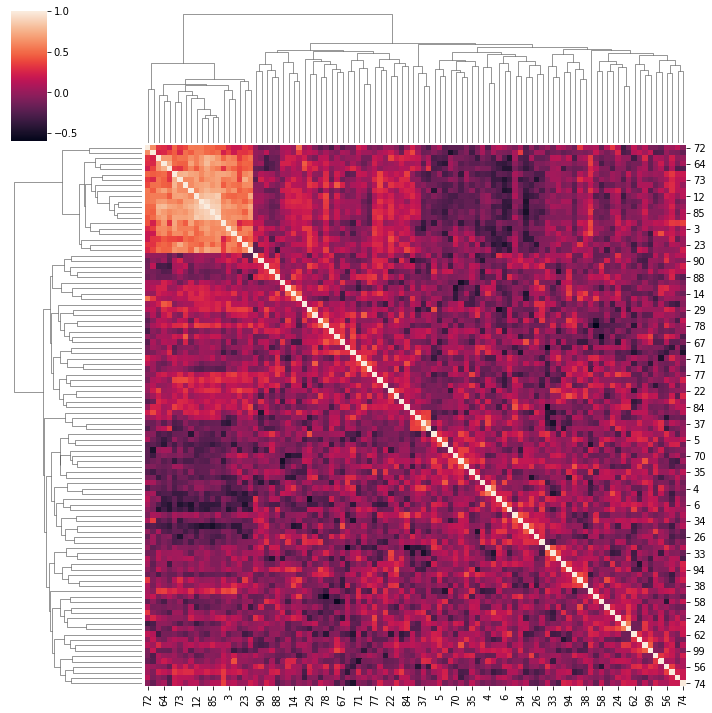

In [31]:
import seaborn as sb
sb.clustermap(artist_sim_matrix)

In [77]:
pca = PCA(n_components=5)
afmxt = pca.fit_transform(aid_embedding_matrix)

/Users/Howard/projects/venvs/lastfm/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  import sys


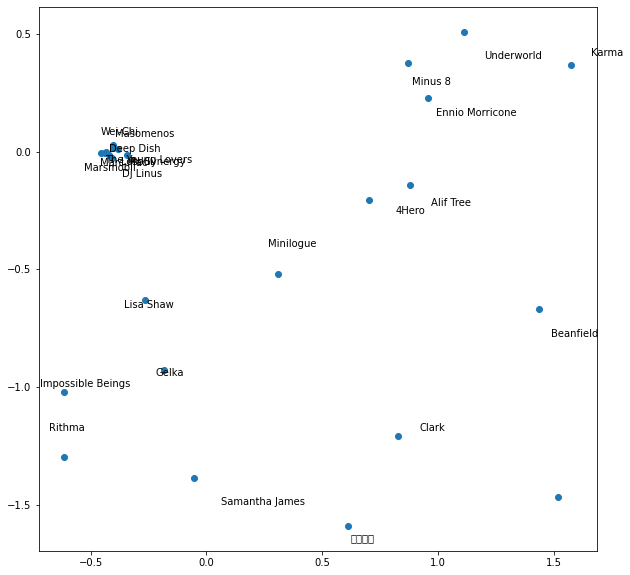

In [92]:
samples = 25
plt.subplots(figsize = (10,10))
plt.scatter(afmxt[:samples,0], afmxt[:samples,1])
for i in range(samples):
    offset_x = (np.random.rand()-0.5)/4
    offset_y = (np.random.rand()-0.5)/4
    plt.annotate(aid_to_aname[str(i)], (afmxt[i,0]+offset_x, afmxt[i,1]+offset_y),textcoords="offset points")

## Sanity check for user embedding

### Baseline averaging model

In [264]:
import json
import os
embedding_dir = "../lastfm/embeddings/baseline/"
embeddings = []
for i in range(1,100):
    fname = embedding_dir+f"embedding_{i}.json"
    with open(fname) as f:
        embedding = json.load(f)
        embeddings.append(convert_to_matrix(embedding))

In [231]:
e1 = embeddings[0]
e2 = embeddings[1]
e3 = embeddings[2]

In [232]:
e1_ind = np.where(np.all(e1, axis=1))
e2_ind = np.where(np.all(e2, axis=1))
e3_ind = np.where(np.all(e3, axis=1))

In [234]:
e1_ind

(array([  2,  10,  11,  15,  17,  18,  20,  24,  27,  33,  40,  52,  53,
         58,  59,  61,  66,  68,  73,  75,  77,  83,  91,  96, 103, 120,
        123, 131, 133, 138, 141, 152, 160, 164, 166, 167, 169, 173, 179,
        181, 187, 205, 221, 232, 234, 238, 259, 260, 261, 265, 266, 268,
        270, 272, 276, 277, 278, 279, 283, 290, 295, 299, 301, 303, 306,
        310, 320, 323, 331, 334, 335, 336, 345, 346, 354, 362, 367, 376,
        377, 378, 380, 383, 386, 387, 403, 408, 410, 423, 441, 455, 470,
        472, 486, 489, 502, 505, 506, 507, 515, 518, 528, 536, 546, 548,
        562, 563, 568, 569, 592, 605, 612, 613, 623, 632, 637, 641, 650,
        652, 667, 670, 677, 679, 681, 685, 693, 699, 701, 705, 714, 723,
        724, 725, 727, 743, 745, 773, 774, 780, 781, 783, 784, 790, 791,
        792, 795, 796, 801, 810, 811, 812, 813, 820, 822, 823, 825, 829,
        833, 834, 836, 840, 853, 862, 863, 874, 875, 879, 888, 891, 906,
        912, 915, 934, 941, 946, 949, 950, 953, 958

In [265]:
# overlap users
active_users = np.zeros((len(embeddings), len(uid_to_userid)))
for i, e in enumerate(embeddings):
    active_users[i] = np.all(e, axis=1)*1

In [271]:
np.where(active_users[0])

(array([ 31,  53,  61,  66,  87, 141, 152, 161, 167, 173, 178, 234, 283,
        290, 295, 301, 331, 345, 380, 387, 403, 412, 421, 423, 472, 505,
        506, 518, 527, 528, 536, 550, 568, 578, 612, 613, 652, 670, 679,
        693, 701, 724, 725, 737, 745, 756, 784, 791, 811, 812, 825, 836,
        855, 862, 863, 879, 888, 890, 906, 915, 921, 934, 953, 958]),)

<AxesSubplot:>

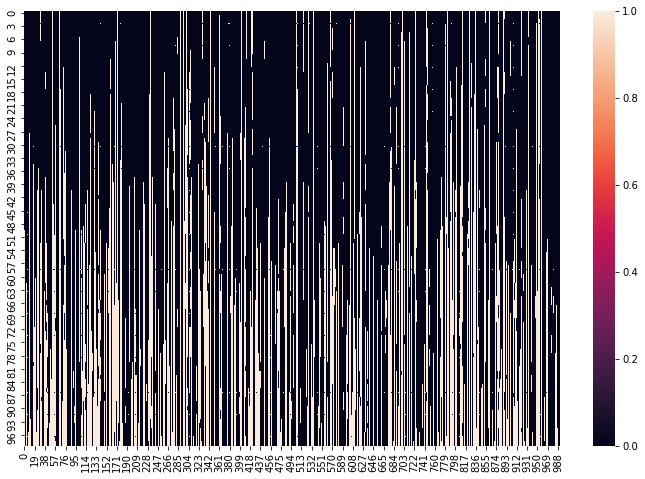

In [266]:
plt.subplots(figsize=(12,8))
sb.heatmap(active_users)

Text(0.5, 1.0, 'tracking f1 and f2 across first 3 windows')

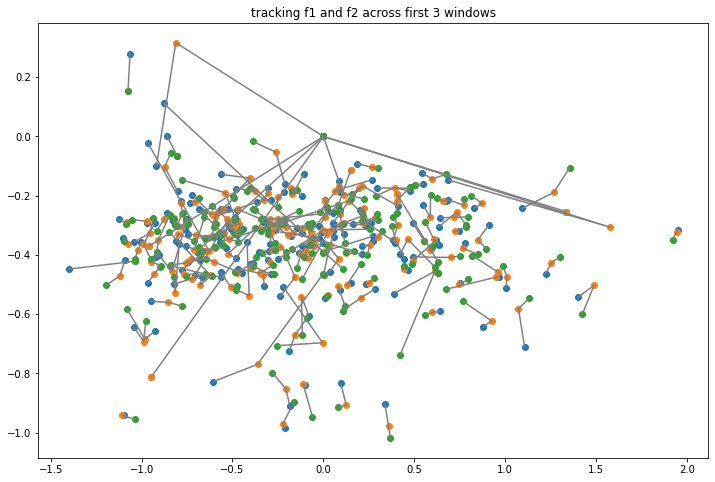

In [233]:
plt.subplots(figsize=(12,8))

f1, f2 = 0, 1

plt.scatter(e1[e1_ind,f1], e1[e1_ind,f2])
plt.scatter(e2[e1_ind,f1], e2[e1_ind,f2])
plt.scatter(e3[e1_ind,f1], e3[e1_ind,f2])

for i in e1_ind:
    x = np.stack((e1[i,f1],e2[i,f1],e3[i,f1]))
    y = np.stack((e1[i,f2],e2[i,f2],e3[i,f2]))
#     if np.sqrt(np.ptp(x)**2+np.ptp(y)**2)>0.001:
#         plt.annotate(str(i), (x[0],y[0]))
    plt.plot(x, y, "grey")
    
plt.title("tracking f1 and f2 across first 3 windows")

### Tracking a single user
- using UMAP to reduce dimension

In [239]:
import umap
reducer = umap.UMAP()

In [236]:
# tracking on a single user
from tracker import track_user
uid = 50
u_embeddings = track_user(uid, "baseline")

In [253]:
active_ind = np.where(np.all(u_embeddings, axis=1))[0]
u_embeddings_active = u_embeddings[active_ind]

In [277]:
reduced_embedding = reducer.fit_transform(u_embeddings_active)
reduced_embedding.shape

(69, 2)

Text(0.5, 1.0, 'user tracking for uid 50')

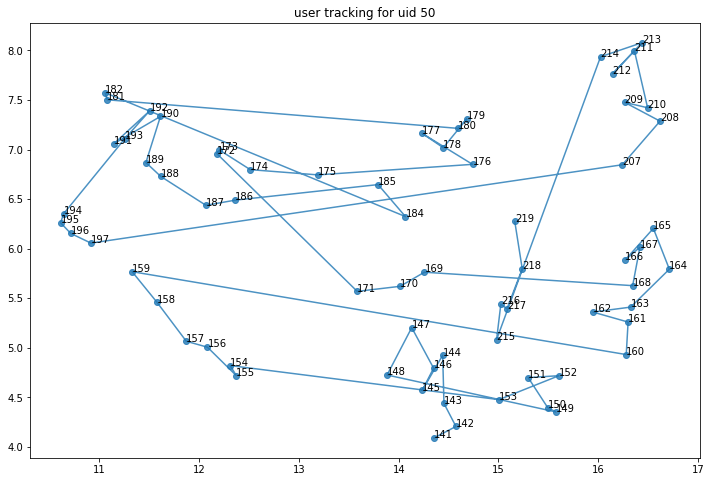

In [278]:
fig, _ = plt.subplots(figsize=(12,8))
plt.plot(reduced_embedding[:,0],reduced_embedding[:,1], "o-", alpha=0.8)
for i in range(len(active_ind)):
    plt.annotate(active_ind[i], (reduced_embedding[i,0], reduced_embedding[i,1]))
plt.title(f"user tracking for uid {uid}")

In [287]:
embedding_diff = []
embedding_diff_to_first = []
base = u_embeddings_active[0]
for e1, e2 in zip(u_embeddings_active[:-1], u_embeddings_active[1:]):
    diff = np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))
    embedding_diff.append(diff)
    diff_to_first = np.dot(base, e2) / (np.linalg.norm(base) * np.linalg.norm(e2))
    embedding_diff_to_first.append(diff_to_first)

### Collaborative Filtering model

In [94]:
data_generator = sliding_window()
data1, i1 = next(data_generator)
data2, i2 = next(data_generator)

In [116]:
for i in range(40):
    data3, i3 = next(data_generator)

### Testing embedding of two seperate runs using the same data

This is to study how variable/stable the embeddings are
- do the columns get rearranged?
- how similar are the embeddings?

In [97]:
data1p = process_encoding(data1)
history1_p1, model1_p1 = prepare_training(data1p, len(uid_to_userid), len(aid_to_artistid))
ufmap1, afmap1 = extract_features(model1_p1, uid_to_userid, aid_to_artistid)

Epoch 1/10
286/286 [==============================] - 2s 3ms/step - loss: 0.2000 - val_loss: 0.0681
Epoch 2/10
286/286 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0327
Epoch 3/10
286/286 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0217
Epoch 4/10
286/286 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0164
Epoch 5/10
286/286 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0121
Epoch 6/10
286/286 [==============================] - 1s 2ms/step - loss: 9.7727e-04 - val_loss: 0.0087
Epoch 7/10
286/286 [==============================] - 0s 2ms/step - loss: 6.1709e-04 - val_loss: 0.0069
Epoch 8/10
286/286 [==============================] - 1s 2ms/step - loss: 5.4950e-04 - val_loss: 0.0057
Epoch 9/10
286/286 [==============================] - 1s 2ms/step - loss: 3.1704e-04 - val_loss: 0.0050
Epoch 10/10
286/286 [==============================] - 1s 2ms/step - loss: 3.7883e-0

In [101]:
data2p = process_encoding(data2)
history_2, model_2 = prepare_training(data2p, len(uid_to_userid), len(aid_to_artistid))
ufmap2, afmap2 = extract_features(model_2, uid_to_userid, aid_to_artistid)

Epoch 1/10
287/287 [==============================] - 1s 2ms/step - loss: 0.1833 - val_loss: 0.0513
Epoch 2/10
287/287 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0295
Epoch 3/10
287/287 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0225
Epoch 4/10
287/287 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0183
Epoch 5/10
287/287 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0151
Epoch 6/10
287/287 [==============================] - 1s 2ms/step - loss: 6.9954e-04 - val_loss: 0.01290e-0
Epoch 7/10
287/287 [==============================] - 0s 2ms/step - loss: 5.7021e-04 - val_loss: 0.0110
Epoch 8/10
287/287 [==============================] - 0s 2ms/step - loss: 3.2459e-04 - val_loss: 0.0091
Epoch 9/10
287/287 [==============================] - 0s 2ms/step - loss: 6.0440e-04 - val_loss: 0.0069
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 3.323

In [255]:
i3

63

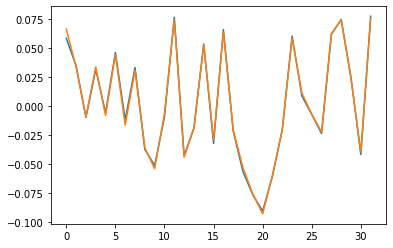

In [115]:
i = 87
plt.plot(ufmap1[i])
plt.plot(ufmap2[i])

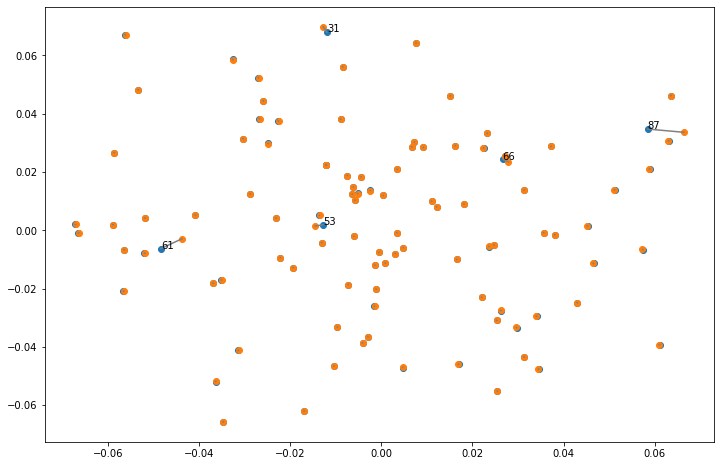

In [114]:
n_samples = 100
plt.subplots(figsize=(12,8))
plt.scatter(ufmap1[:n_samples,0],ufmap1[:n_samples,1])
plt.scatter(ufmap2[:n_samples,0],ufmap2[:n_samples,1])
for i in range(len(ufmap1[:n_samples])):
    x = np.stack((ufmap1[i,0],ufmap2[i,0]))
    y = np.stack((ufmap1[i,1],ufmap2[i,1]))
    if np.sqrt(np.ptp(x)**2+np.ptp(y)**2)>0.001:
        plt.annotate(str(i), (x[0],y[0]))
    plt.plot(x, y, "grey")

In [286]:
mtx1, mtx2, disparity = procrustes(ufmap1, ufmap2)
disparity

1.1428014864713738e-30

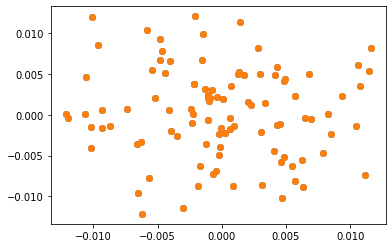

In [287]:
n_samples = 100
plt.scatter(mtx1[:n_samples,0],mtx1[:n_samples,1])
plt.scatter(mtx2[:n_samples,0],mtx2[:n_samples,1])
for i in range(len(mtx1[:n_samples])):
    x = np.stack((mtx1[i,0],mtx2[i,0]))
    y = np.stack((mtx1[i,1],mtx2[i,1]))
    plt.plot(x, y, "grey")